# Predicting Dog Breeds
## Assignment 2

### Outline
1. Importing Libraries
2. Exploratory analysis
3. Loading data
4. Modelling
    - Image data augmentation
    - Modelling with pretrained models
    - Modelling without pretrained models
        - With BatchNormalization
        - Without BatchNormalization
5. Conclusion

### importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import os
import numpy as np


# sklearn
from sklearn.preprocessing import LabelEncoder


# keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

from keras.layers import Concatenate, Dropout, Conv2D, Conv2DTranspose, Add
from keras.layers import Dense, Flatten, Input, Dropout, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from keras.preprocessing.image import ImageDataGenerator
from natsort import natsorted




Using TensorFlow backend.


In [2]:
train_images_dir='../data/DAT300/train/'
test_images_dir='../data/DAT300/test/'

# soring directory based in nemerical order sort
train_imgs = natsorted(os.listdir(train_images_dir)) # contain image .jpg files/ file names

### Exploratory Analysis

#### Grayscale images

In [5]:
X = [cv2.imread(train_images_dir + img, cv2.IMREAD_GRAYSCALE) for img in tqdm(train_imgs[:100])]

100%|██████████| 100/100 [00:00<00:00, 975.06it/s]


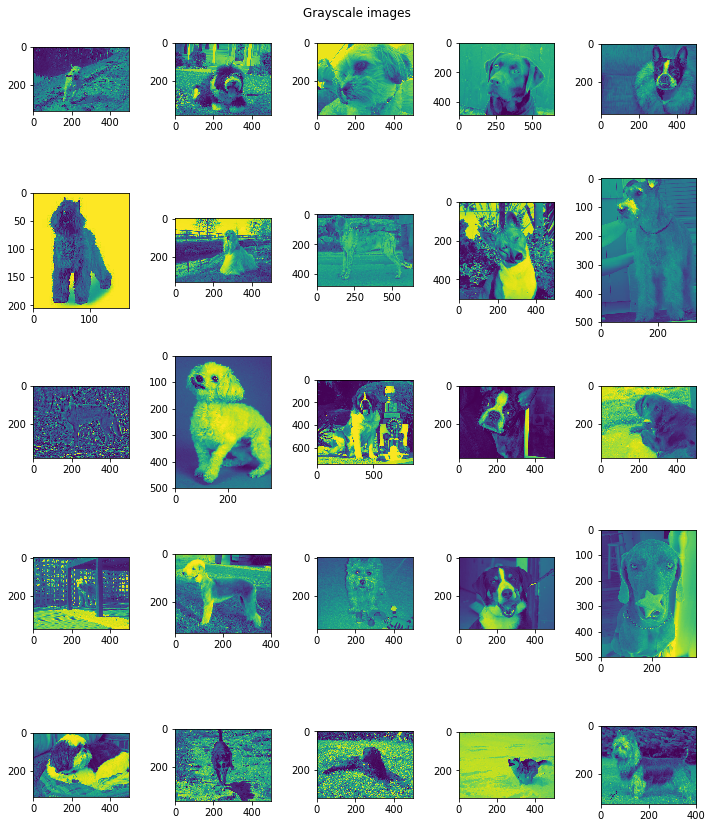

In [6]:
fig, axx = plt.subplots(5, 5, figsize=(10,12))
idx_img = 0
for i in range(5):
    for j in range(5):
        axx[i,j].imshow(X[idx_img])
        idx_img+=1
# plt.title('Grayscale images') # cannot use this for subplots overall t
fig.suptitle('Grayscale images')
fig.tight_layout() # improve spacing or remove overlapping of images
plt.show()

#### RGB Images

In [7]:
X = [cv2.imread(train_images_dir + img, cv2.IMREAD_COLOR) for img in tqdm(train_imgs[:100])]

100%|██████████| 100/100 [00:00<00:00, 540.99it/s]


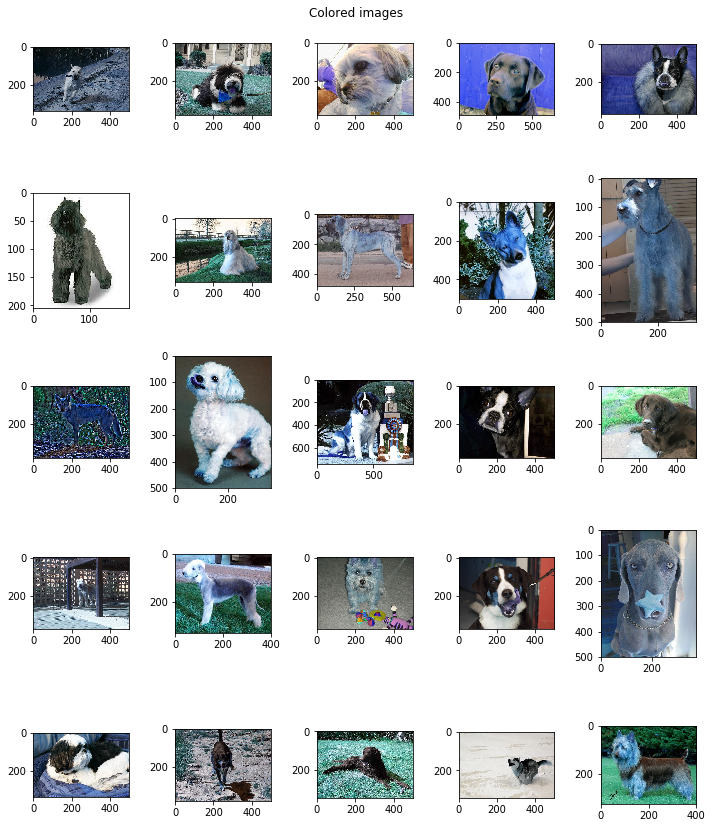

In [8]:
fig, axx = plt.subplots(5, 5, figsize=(10,12))
idx_img = 0
for i in range(5):
    for j in range(5):
        axx[i,j].imshow(X[idx_img])
        idx_img+=1
plt.suptitle('Colored images')
fig.tight_layout() # improve spacing or remove overlapping of images
plt.show()

As obvious from above figures, the size of the images is different, and some are quite large. We need to resize these images before fitting into a model. The images wll be resized to (150, 150) to save memory space.

We will sketch different interplotation methods to resize image

In [9]:
X[0].shape

(333, 500, 3)

In [10]:
original_img = X[0]
inter_area = cv2.resize(original_img, (150, 150), interpolation = cv2.INTER_AREA)
inter_cubic = cv2.resize(original_img, (150, 150), interpolation = cv2.INTER_CUBIC)
inter_nearest = cv2.resize(original_img, (150, 150), interpolation = cv2.INTER_NEAREST)
inter_linear = cv2.resize(original_img, (150, 150), interpolation = cv2.INTER_LINEAR)

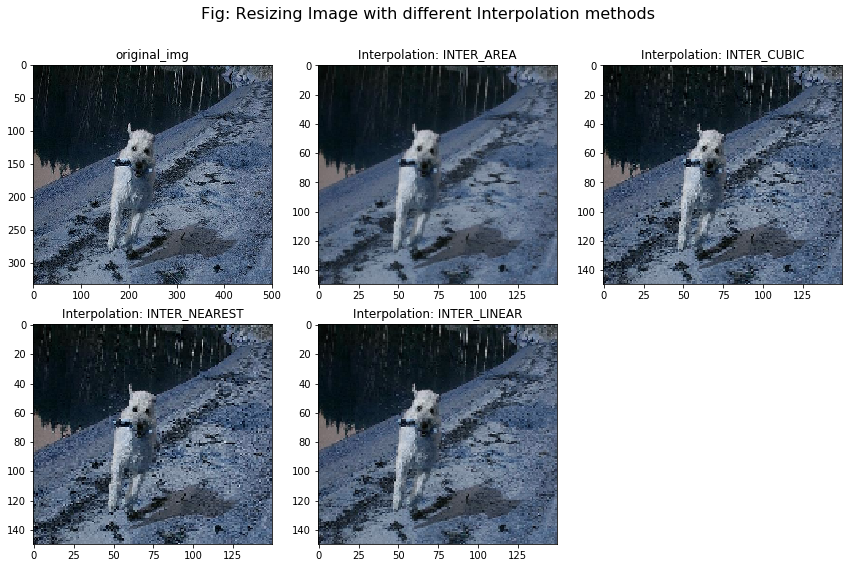

In [11]:
img_list = [original_img, inter_area, inter_cubic, inter_nearest, inter_linear]
txt_list = ['original_img', 'Interpolation: INTER_AREA', 'Interpolation: INTER_CUBIC', 
            'Interpolation: INTER_NEAREST', 'Interpolation: INTER_LINEAR']
fig, axx = plt.subplots(2, 3, figsize=(12,8))
idx_img = 0
for i in range(2):
    for j in range(3):
        if idx_img<5:
            axx[i,j].imshow(img_list[idx_img], aspect="auto")
            axx[i,j].set_title(txt_list[idx_img])
            idx_img+=1
        else:
            axx[i,j].axis('off') # skipping last subplot area


fig.suptitle('Fig: Resizing Image with different Interpolation methods', fontsize=16)
fig.tight_layout() # improve spacing or remove overlapping of images
fig.subplots_adjust(top=0.88) # When using tight_layout, need to 
                              # increase distance of sublpots from main title

plt.show()

It appears from the above images that intepolation with INTER_AREA removes the noise from image. 

### Reading images

Resizing and reading images using cv2 library

In [3]:
train_images_dir='../data/DAT300/train/'
test_images_dir='../data/DAT300/test/'

# soring directory based in nemerical order sort
train_imgs = natsorted(os.listdir(train_images_dir)) # contain image .jpg files/ file names
img_size = 150
# reading files by iterating using tqdm iterator
X = [cv2.imread(train_images_dir+img, cv2.IMREAD_COLOR) for img in tqdm(train_imgs)]



100%|██████████| 10290/10290 [00:26<00:00, 386.91it/s]


In [4]:
# Resizing images if image is large then it is shrink by INTER_AREA interpolation, 
# otherwise zooming with INTER_LINEAR interpolation
for i in range(len(X)):
    if X[i].shape[0]>150 or X[i].shape[1]>150:
        X[i] = cv2.resize(X[i], (150, 150), interpolation = cv2.INTER_AREA)
    else:
        X[i] = cv2.resize(X[i], (150, 150), interpolation = cv2.INTER_LINEAR)



Images after resizing to required shape

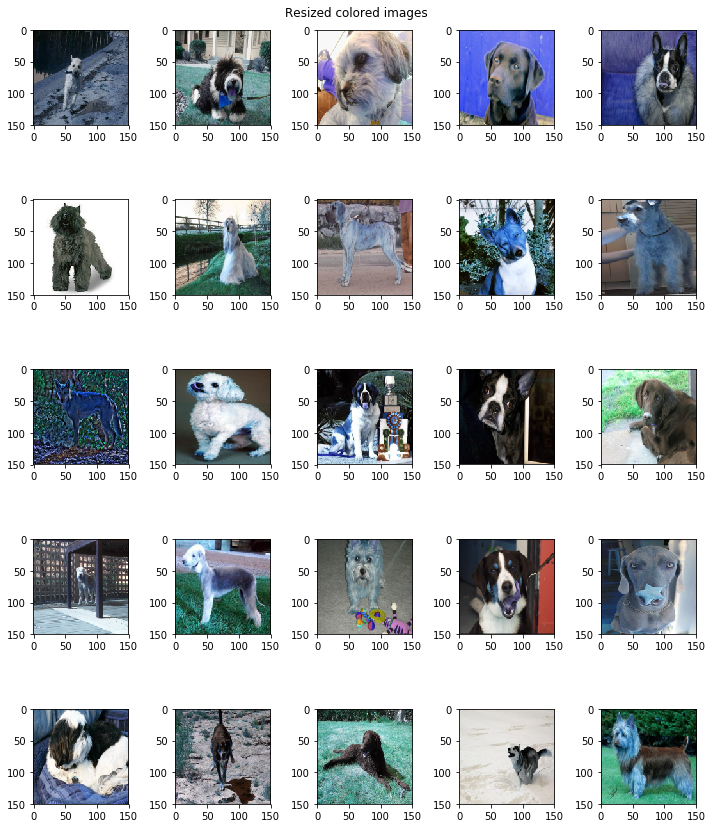

In [17]:
fig, axx = plt.subplots(5, 5, figsize=(10,12))
idx_img = 0
for i in range(5):
    for j in range(5):
        axx[i,j].imshow(X[idx_img])
        idx_img+=1
plt.suptitle('Resized colored images')
fig.tight_layout() # improve spacing or remove overlapping of images
plt.show()

In [10]:
X = np.array(X)/255
# X = np.expand_dims(X,axis=3) # if needed to expand. Usually need to expand grayscale 
                               # arrays, to make them three dimensional
X.shape

(10290, 150, 150, 3)

Converting labels into dummy matrix using np_utils.to_categorical from keras

In [9]:
labels = pd.read_csv('../data/DAT300/labels.csv')
labels_name = list(labels['breed'].unique())
labels_name.sort() # inplacing sorting
# encode class values as integers
label_encoder = LabelEncoder()
label_encoder.fit(labels_name)
encoded_Y = label_encoder.transform(np.array(labels.iloc[:,1]))
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
dummy_y.shape

(10290, 120)

### Modeling

#### Image data augmentation

In [11]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.2,
    horizontal_flip=False, rescale=1./255)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, random_state=23, 
                                                      test_size = 0.05)
datagen.fit(X_train)

#### Modeling with pretrained models

In this model, we will use 'InceptionResNetV2' model with pretrained weights from imagenet. All the layers will be frozen except last a few in this model. 

The pretrained weights of first few layers are usually frozen in pretrained network as by keeping weights intact in these layers that capture universal features like  edges and curves might be helpful in image problems.  https://flyyufelix.github.io/2016/10/03/fine-tuning-in-keras-part1.html


In [22]:
def create_model(input_tuple_shape):
    
    # weights=None to randomly intialize weights
    # weights='imagenet' to use imagenet pretrained weights
    # include_top=True to include top fully connected layers
    
    base_model_inception = InceptionResNetV2(weights='imagenet', include_top=False,
                                       input_shape=input_tuple_shape)
    
    

    # Check the trainable status of the individual layers
    #for layer in base_model_inception.layers:
     #   print(layer, layer.trainable)
    
    # input_shape = Input(input_tuple_shape)
    
    # to remove last flatten and softmax layers if include_top=True. 
    # x = base_model_inception.layers[-2].output 


    x = base_model_inception.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)

    x = Dropout(0.25)(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(120, activation='softmax')(x)

    model = Model(inputs=base_model_inception.input, outputs=x)
    # Freeze the layers except the last 4 layers
    for layer in base_model_inception.layers[:-4]:
        layer.trainable = False
    model.summary()
    return model


In [23]:
model = create_model(X_train.shape[1:])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

conv2d_98 (Conv2D)              (None, 7, 7, 128)    139264      block17_5_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, 7, 7, 128)    384         conv2d_98[0][0]                  
__________________________________________________________________________________________________
activation_98 (Activation)      (None, 7, 7, 128)    0           batch_normalization_98[0][0]     
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 7, 7, 160)    143360      activation_98[0][0]              
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, 7, 7, 160)    480         conv2d_99[0][0]                  
__________________________________________________________________________________________________
activation

- ModelCheckpoint is used here to save best model based on validation loss in file 'model_save.hdf5'. 
- In order to reduce learning rate by a factor 0.1 if val_loss will not decrease in each next 5 iterations after best validation_loss, ReduceLROnPlateau is used here.
- EarlyStopping is used to stop fitting if val_loss will not decrease in each next 10 iterations after best validation_loss.
- The model is compiled with optimizer 'adam' and loss 'categorical_crossentropy'. 

In [24]:
model_check = ModelCheckpoint('model_save.hdf5', monitor='val_loss', save_best_only=True)
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model.compile('adam', loss='categorical_crossentropy') # compile model is a prerequisite to fit a model


# fits the model on batches with real-time data augmentation:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping, lr_reduced, 
                                                                 model_check],
                    steps_per_epoch=len(X_train) / 32, epochs=100)

Epoch 1/100
306/305 [==============================] - 51s 167ms/step - loss: 4.4224 - val_loss: 4.6228
Epoch 2/100
306/305 [==============================] - 42s 138ms/step - loss: 3.7431 - val_loss: 4.0898
Epoch 3/100
306/305 [==============================] - 42s 138ms/step - loss: 3.4928 - val_loss: 3.3172
Epoch 4/100
306/305 [==============================] - 42s 138ms/step - loss: 3.3196 - val_loss: 3.5019
Epoch 5/100
306/305 [==============================] - 42s 138ms/step - loss: 3.2196 - val_loss: 2.9254
Epoch 6/100
306/305 [==============================] - 42s 137ms/step - loss: 3.1365 - val_loss: 3.4407
Epoch 7/100
306/305 [==============================] - 42s 138ms/step - loss: 3.0299 - val_loss: 3.1493
Epoch 8/100
306/305 [==============================] - 42s 138ms/step - loss: 2.9719 - val_loss: 3.3221
Epoch 9/100
306/305 [==============================] - 42s 138ms/step - loss: 2.9000 - val_loss: 3.2993
Epoch 10/100
306/305 [==============================] - 42s 138m

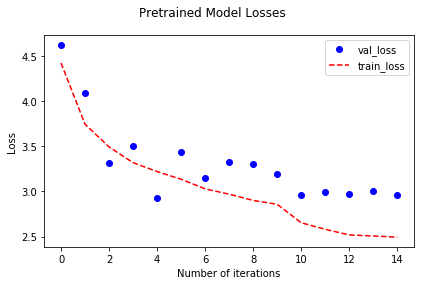

In [25]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))

line1, = ax.plot(range(len(history.history['val_loss'])), 
                 history.history['val_loss'], 'bo',label='val_loss')
line2, = ax.plot(range(len(history.history['loss'])), 
                 history.history['loss'],'r--', label='train_loss')

plt.xlabel('Number of iterations')
plt.ylabel('Loss')

plt.suptitle('Pretrained Model Losses')
ax.legend()
plt.tight_layout()
fig.subplots_adjust(top=0.88) # When using tight_layout, need to 
                              # increase distance of sublpots from main title

plt.show()

#### Modelling without pretrained models
##### With BatchNormalization

In [13]:
def create_model(input_tuple_shape):
    
    activation_ = 'relu'
    input_shape = Input(input_tuple_shape)
    
    x = Conv2D(32, (3,3), activation=activation_, padding='same')(input_shape)
    x = Dropout(0.1)(x) # to remove noise 

    x = Conv2D(48, (3,3), activation=activation_, padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3,3), activation=activation_, padding='same')(x)
    x = Conv2DTranspose(64, (3,3), activation=activation_, padding='same')(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3,3), activation=activation_, padding='same')(x)
    x = Conv2D(128, (3,3), activation=activation_, padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3,3), activation=activation_, padding='same')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    #x = Dropout(0.25)(x)
    #x = Dense(512, activation='relu')(x)

    x = Dense(120, activation='softmax')(x)
    model = Model(inputs=input_shape, outputs=x)
  
    model.summary()
    return model

In [14]:
model = create_model(X_train.shape[1:])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 48)      13872     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 48)        192       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        27712     
__________

In [39]:
# To free memory using garbage collector
import gc
gc.collect()

22592

In [15]:
model_check = ModelCheckpoint('model_save.hdf5', monitor='val_loss', save_best_only=True)
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model.compile('adam', loss='categorical_crossentropy') # compile model is a prerequisite to fit a model


# fits the model on batches with real-time data augmentation:
history1 = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                               validation_data=(X_valid, y_valid),
                               callbacks=[early_stopping, lr_reduced, model_check],
                               steps_per_epoch=len(X_train) / 32, epochs=100)

Epoch 1/100
306/305 [==============================] - 47s 152ms/step - loss: 4.9211 - val_loss: 15.5133
Epoch 2/100
306/305 [==============================] - 42s 138ms/step - loss: 4.7847 - val_loss: 15.7307
Epoch 3/100
306/305 [==============================] - 42s 138ms/step - loss: 4.7814 - val_loss: 15.5949
Epoch 4/100
306/305 [==============================] - 42s 137ms/step - loss: 4.7819 - val_loss: 15.6407
Epoch 5/100
306/305 [==============================] - 42s 138ms/step - loss: 4.7815 - val_loss: 15.6499
Epoch 6/100
306/305 [==============================] - 42s 138ms/step - loss: 4.7813 - val_loss: 15.6468

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/100
306/305 [==============================] - 42s 137ms/step - loss: 4.7792 - val_loss: 15.6490
Epoch 8/100
306/305 [==============================] - 42s 139ms/step - loss: 4.7791 - val_loss: 15.6543
Epoch 9/100
306/305 [==============================] - 42s 138ms/step - loss: 

In [18]:
def plt_loss(history1, title='Figure'):
    fig, ax = plt.subplots(figsize=(6, 4))

    line1, = ax.plot(range(len(history1.history['val_loss'])), history1.history['val_loss'], 'bo',label='val_loss')
    line2, = ax.plot(range(len(history1.history['loss'])), history1.history['loss'],'r--', label='train_loss')

    plt.xlabel('Number of iterations')
    plt.ylabel('Loss')
    
    plt.suptitle(title)
    ax.legend()
    plt.tight_layout()
    fig.subplots_adjust(top=0.88) # When using tight_layout, need to 
                                  # increase distance of sublpots from main title
    plt.show()
    

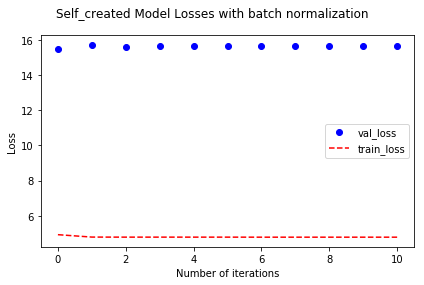

In [19]:
plt_loss(history1, title='Self_created Model Losses with batch normalization')

##### Without BatchNormalization

In [21]:
def create_model(input_tuple_shape):
    
    activation_ = 'relu'
    input_shape = Input(input_tuple_shape)
    
    x = Conv2D(32, (3,3), activation=activation_, padding='same')(input_shape)
    x = Dropout(0.1)(x) # to remove noise 

    x = Conv2D(48, (3,3), activation=activation_, padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = BatchNormalization()(x)

    x = Conv2D(64, (3,3), activation=activation_, padding='same')(x)
    x = Conv2DTranspose(64, (3,3), activation=activation_, padding='same')(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3,3), activation=activation_, padding='same')(x)
    x = Conv2D(128, (3,3), activation=activation_, padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = BatchNormalization()(x)

    x = Conv2D(64, (3,3), activation=activation_, padding='same')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    #x = Dropout(0.25)(x)
    #x = Dense(512, activation='relu')(x)

    x = Dense(120, activation='softmax')(x)
    model = Model(inputs=input_shape, outputs=x)
  
    model.summary()
    return model

In [22]:
model = create_model(X_train.shape[1:])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 48)      13872     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 64)        27712     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 75, 75, 64)        36928     
__________

In [23]:
model_check = ModelCheckpoint('model_save.hdf5', monitor='val_loss', save_best_only=True)
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model.compile('adam', loss='categorical_crossentropy') # compile model is a prerequisite to fit a model


# fits the model on batches with real-time data augmentation:
history1 = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                               validation_data=(X_valid, y_valid),
                               callbacks=[early_stopping, lr_reduced, model_check],
                               steps_per_epoch=len(X_train) / 32, epochs=100)

Epoch 1/100
306/305 [==============================] - 44s 144ms/step - loss: 4.7878 - val_loss: 4.7845
Epoch 2/100
306/305 [==============================] - 42s 136ms/step - loss: 4.7839 - val_loss: 4.7826
Epoch 3/100
306/305 [==============================] - 43s 141ms/step - loss: 4.7824 - val_loss: 4.7826
Epoch 4/100
306/305 [==============================] - 44s 144ms/step - loss: 4.7817 - val_loss: 4.7825
Epoch 5/100
306/305 [==============================] - 43s 141ms/step - loss: 4.7814 - val_loss: 4.7828
Epoch 6/100
306/305 [==============================] - 43s 140ms/step - loss: 4.7813 - val_loss: 4.7828
Epoch 7/100
306/305 [==============================] - 43s 140ms/step - loss: 4.7812 - val_loss: 4.7829
Epoch 8/100
306/305 [==============================] - 45s 148ms/step - loss: 4.7813 - val_loss: 4.7825
Epoch 9/100
306/305 [==============================] - 43s 140ms/step - loss: 4.7807 - val_loss: 4.7830

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0001

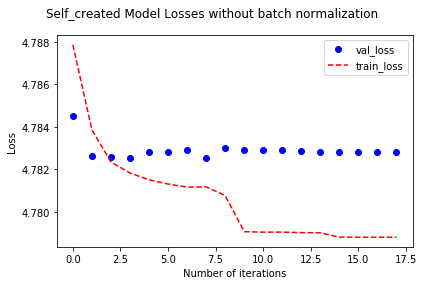

In [24]:
plt_loss(history1, title='Self_created Model Losses without batch normalization')

### Loading and predicting test data

In [ ]:
test_imgs = natsorted(os.listdir(test_images_dir)) # contain image .jpg files/ file names

# reading files by iterating using tqdm iterator
X_test = [cv2.imread(test_images_dir+img, cv2.IMREAD_COLOR) for img in tqdm(test_imgs)]

for i in range(len(X_test)):
    if X_test[i].shape[0]>150 or X_test[i].shape[1]>150:
        X_test[i] = cv2.resize(X_test[i], (150, 150), interpolation = cv2.INTER_AREA)
    else:
        X_test[i] = cv2.resize(X_test[i], (150, 150), interpolation = cv2.INTER_LINEAR)


X_test = np.array(X_test)/255
X_test.shape


In [ ]:
from keras.models import load_model
model = load_model('model_save.hdf5')

predicted = model.predict(X_test)
df_pred = pd.DataFrame(predicted)
col = list(labels['breed'].unique())

# sorting to avoid conflicts with np_utils.to_categorical generated label encoders that 
# assigns number to classes based on alphabet-wise names
col.sort() 
df_pred.columns = col
df_pred['id'] = df_pred.index
df_pred.to_csv('submission_file.csv', index=False)

### Conclusion
- In our case, pretrained models worked well which means the models are well-established to handle image classification related tasks.
- It was observed that freezing layers or not freezing layers of pretrained layers does not impact results significantly. We found both 'None' and 'imagenet' cases for weights worked almost same which means pre-built architecture is good enough to train weights with new images as well.
- In our case, it was not possible to get any reasonable (or good) results without image augmentation.
- When we used Batch normalization in our self-created model, the model overfits (training loss was around 4.77, validation loss around 15.68). Without batch normalization, we did not observe overfitting.
- The number of parameters in pretrained model are 69,079,896 (but trainable params are only 17,939,576 because others are frozen), while in our own model, total parameters are 21,732,328. So both of our models took almost same time per epoch.

